In [109]:
from pathlib import Path
import src.simulations.experiment_fxns as exp

FILE_NAME = "spectrogram.pk1"
save_path = Path("/Users/megyoung/continual_learning_simulations/results/trained_models/" + FILE_NAME)
run_experiment(task_id=0, thetas=[0,90], spectrogram=True, num_notes=7, p_train=1, num_trials=10000, learning_rate=0.01, rpe=True, rpe_type="partial", tonotopy=True, save_data=True, save_path=save_path)

In [88]:
"""This file specifies all the functions needed to run a complete simulation of 
our continual learning task."""

import random
import pickle
import numpy as np
import torch
from torch import nn
from torch import optim

def get_trial_type(p_train=0.8, p_test=0.5):
    """This function determines the type of the upcoming trial.

    Args:
        p_train (float, optional): Probability of a train trial (vs. test/validation trial). Defaults to 0.8.
        p_test (float, optional): If not a train trial, probability of a test trial (vs. validation trial). Defaults to 0.5.

    Returns:
        string: Trial type of the upcoming trial. Either "train", "test", or "validation".
    """
    train = random.random()
    if train < p_train:
        return "train"
    else:
        test = random.random()
        if test < p_test:
            return "test"
        else:
            return "validation"

def get_general_stimulus(p_stim_right=0.5):
    """_summary_

    Args:
        p_stim_right (float, optional): _description_. Defaults to 0.5.

    Returns:
        _type_: _description_
    """
    stim_right = random.random()
    if stim_right < p_stim_right:
        stim = torch.tensor([1,1,0], dtype=torch.float32)
        correct_choice = 1
    else:
        stim = torch.tensor([1,0,1], dtype=torch.float32)
        correct_choice = 0
    return stim, correct_choice

def get_auditory_stimulus(trial_type, task_id=0, thetas=[0,90], p_stim_right=0.5, num_notes=7):
    """This function returns the stimulus / input to the network for a given trial

    Args:
        trial_type (string): Type of the current trial. Either "train", "test", or "validation".
        task_id (int, optional): Number of the current task. Either 0 for task 1 or 1 for task 2. Defaults to 0.
        thetas (list, optional): Angles for the right choice sounds for tasks 1 (element 0) and 2 (element 1). 
                                 The left choice sounds are just those angles + 180 degrees. Defaults to [0,90].
        p_stim_right (float, optional): Probability that the stimulus will be that associated with a right choice. Defaults to 0.5.
        num_notes (int, optional): Number of notes used to create the polyphonic sound. Defaults to 7.

    Returns:
        stim (num_notes + 1 tensor): The first element is a constant bias term; the remaining num_notes elements are the
                        amplitudes of the notes for the sound stimulus (i.e., the spectrogram of the stimulus).
        curr_theta (float): Angle for the current task.
        correct_choice (int): Correct action associated with the current stimulus. Either 0 (left choice) or 1 (right choice).
    """

    def get_amplitudes(theta, n, order):
        """This function returns the spectrogram of the auditory stimulus.

        Args:
            theta (int): Angle of the sound on the ring.
            n (int): Number of notes used to create the polyphonic sound.
            order (num_notes + 1 array): Optimal order of the frequencies that maximally preserves perceptual uniformity across the ring.

        Returns:
            num_notes + 1 array: Coefficients, representing the power of each frequency, ordered according to the order specified as the input.
        """
        positions = np.linspace(0., 360., n + 1)[:-1]
        positions = np.deg2rad(positions) + np.deg2rad(theta)
        return (0.5 * (np.cos(positions) + 1.))[order]
      
    optimal_order = np.asarray([1, 4, 7, 2, 3, 5, 6]) - 1

    if trial_type == "train":
        stim_right = random.random()
        if stim_right < p_stim_right:
            stim = np.ones(shape=num_notes + 1)
            stim[1:] = get_amplitudes(thetas[task_id], num_notes, optimal_order)
            stim = torch.tensor(stim, dtype=torch.float32)
            curr_theta = thetas[task_id]
            correct_choice = 1
        else:
            stim = np.ones(shape=num_notes + 1)
            stim[1:] = get_amplitudes(thetas[task_id] + 180, num_notes, optimal_order)
            stim = torch.tensor(stim, dtype=torch.float32)
            curr_theta = thetas[task_id] + 180
            correct_choice = 0
    elif trial_type == "validation":
        stim_right = random.random()
        if stim_right < p_stim_right:
            stim = np.ones(shape=num_notes + 1)
            stim[1:] = get_amplitudes(thetas[0], num_notes, optimal_order)
            stim = torch.tensor(stim, dtype=torch.float32)
            curr_theta = thetas[0]
            correct_choice = 1
        else:
            stim = np.ones(shape=num_notes + 1)
            stim[1:] = get_amplitudes(thetas[0] + 180, num_notes, optimal_order)
            stim = torch.tensor(stim, dtype=torch.float32)
            curr_theta = thetas[0] + 180
            correct_choice = 0
    elif trial_type == "test":
        curr_theta = random.random()*360
        stim = np.ones(shape=num_notes + 1)
        stim[1:] = get_amplitudes(curr_theta, num_notes, optimal_order)
        stim = torch.tensor(stim, dtype=torch.float32)
        if np.abs(curr_theta - thetas[task_id]) <= 90:
            correct_choice = 1
        else:
            correct_choice = 0
    return stim, curr_theta, correct_choice

def select_action(q_values, beta=2.5):
    """This function implements softmax action selection.

    Args:
        q_values (_type_): Action values.
        beta (float, optional): Inverse temperature parameter. Defaults to 1000.0.

    Returns:
        action (int): Chosen action. Either 0 (left choice) or 1 (right choice).
        probabilities (num_actions array): Probability of choosing either 0 (left choice) or 1 (right choice).
    """
    exponent = np.exp(beta * q_values)
    probabilities = exponent / np.sum(exponent)
    action = np.random.choice(range(len(q_values)), p=probabilities)
    return action, probabilities, beta

def get_general_reward(trial_type, action, correct_choice, p_reward=0.5):
    """_summary_

    Args:
        trial_type (_type_): _description_
        action (_type_): _description_
        correct_choice (_type_): _description_
        p_reward (float, optional): _description_. Defaults to 0.5.

    Returns:
        _type_: _description_
    """
    if trial_type == "train":
        if action == correct_choice:
            return 1
        else:
            return 0
    else:
        reward = random.random()
        if reward < p_reward:
            return 1
        else:
            return 0

def get_auditory_reward(trial_type, curr_theta, action, task_id=0, thetas=[0,90], p_reward=0.5):
    """This function determines the reward delivered on a given trial.

    Args:
        trial_type (string): The type of the current trial. Either train, test, or validation.
        curr_theta (float): The theta used to generate the spectrogram for the stimulus for the current trial.
        action (int): Action the agent chose. Either 0 (left choice) or 1 (right choice)
        task_id (int, optional): The number of the task. Either 0 (task 1) or 1 (task 2).
        thetas (list, optional): Angles for the right choice sounds for tasks 1 (element 0) and 2 (element 1). 
                                 The left choice sounds are just those angles + 180 degrees. Defaults to [0,90].
        p_reward (float, optional): Probability that the current trial is rewared for validation and test trials. Defaults to 0.5.

    Returns:
        int: Indicates presence or absence of reward.
    """
    if trial_type == "train":
        # If the current angle is the first sound of the task, then reward the right choice
        if curr_theta == thetas[task_id]:
            if action == 1:
                return 1
            else:
                return 0
        # Otherwise, reward left choice
        else:
            if action == 0:
                return 1
            else:
                return 0
    else:
        reward = random.random()
        if reward < p_reward:
            return 1
        else:
            return 0

def run_experiment(task_id=0, thetas=[0,90], spectrogram=True, num_notes=7, p_train=0.8, num_trials=10000, learning_rate=0.1, rpe=True, rpe_type="full", tonotopy=False, save_data=True, save_path=None):
    """This function runs an experiment similar to that used to train the animals.

    Args:
        task_id (int, optional): The number of the task. Either 0 (task 1) or 1 (task 2). Defaults to 0.
        thetas (list, optional): Angles for the right choice sounds for tasks 1 (element 0) and 2 (element 1). 
                                 The left choice sounds are just those angles + 180 degrees. Defaults to [0,90].
        num_notes (int, optional): Number of notes used to create the polyphonic sound. Defaults to 7.
        num_trials (int, optional): Number of trials in the experiment. Defaults to 10000.
        learning_rate (float, optional): Learning rate for the network. Defaults to 0.1.
        rpe (bool, optional): If true, then the network learns via reinforcement learning; if false, the network learns via supervised learning. Defaults to True.
        rpe_type (str, optional): Specifies the type of the RPE signal, either "full" or "partial". Defaults to "full".
        tonotopy (bool, optional): If true, then the first layer weights are diagonal, motivated by the existence of tonotopy in auditory cortex. Defaults to False.
        save_data (bool, optional): If true, after every iteration, this function saves a dictionary with relevant trial variables. Defaults to True.
        save_path (pathlib Path object): Path to where data should be saved. Defaults to None.
    """
    if spectrogram:
        model = DeepAuditoryDiscriminationNetwork(rpe=rpe, rpe_type=rpe_type, tonotopy=tonotopy, num_notes=num_notes)
    else:
        num_notes = 2
        model = DeepAuditoryDiscriminationNetwork(rpe=rpe, rpe_type=rpe_type, tonotopy=tonotopy, num_notes=num_notes)
    data = []

    # In the supervised version of the model, the output of the network reflects the probabilities of choosing left or right,
    # which is then directly compared to the correct probabilities, either [1,0] for the left choice or [0,1] for the right choice.
    if not model.rpe:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()

        for i in range(num_trials):
            # Determine the trial type, either train, test, or validation
            trial_type = get_trial_type(p_train=p_train)

            # Choose a stimulus, keeping track of the current theta on the ring and the correct choice given an optimal
            # linear decision boundary
            if spectrogram:
                curr_stimulus, curr_theta, correct_choice = get_auditory_stimulus(trial_type, task_id, thetas)
            else:
                curr_stimulus, correct_choice = get_general_stimulus()

            # Assign the correct probabilities for each action
            if correct_choice == 0:
                target_action_probabilities = torch.tensor([1,0], dtype=torch.float32)
            elif correct_choice == 1:
                target_action_probabilities = torch.tensor([0,1], dtype=torch.float32)
            
            # The output of the network are the probabilities of choosing left or right.
            action_probabilities = model(curr_stimulus)

            # To track the accuracy of the model, select an action based on those probabilities
            action, _, beta = select_action(action_probabilities.clone().detach().numpy().copy())
            
            loss = criterion(action_probabilities, target_action_probabilities)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if save_data:
                if spectrogram:
                    trial_data = {
                        "model": model,
                        "loss": loss.item(),
                        "trial_type": trial_type,
                        "curr_stimulus": curr_stimulus.clone().detach().numpy().copy(),
                        "curr_theta": curr_theta,
                        "correct_choice": correct_choice,
                        "action": action,
                        "action_probabilities": action_probabilities.clone().detach().numpy().copy(),
                    }
                else:
                    trial_data = {
                        "model": model,
                        "loss": loss.item(),
                        "trial_type": trial_type,
                        "curr_stimulus": curr_stimulus.clone().detach().numpy().copy(),
                        "correct_choice": correct_choice,
                        "action": action,
                        "action_probabilities": action_probabilities.clone().detach().numpy().copy(),
                    }
                data.append(trial_data)
                with open(save_path, 'wb') as pickle_file:
                    pickle.dump(data, pickle_file)
    
    # In the reinforcement version of the model, the output of the network reflects the Q-values associated with choosing left of right,
    # which are updated based on the RPE.
    else:
        if model.rpe_type == "full":
            optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        elif model.rpe_type == "partial":
            optimizer = optim.SGD([
                {'params': model.l1_weights},
                {'params': model.l2_weights_const},
                {'params': model.l2_weights_stim}
            ], lr=learning_rate)
        criterion = nn.MSELoss()
        
        for i in range(num_trials):
            # Determine the trial type, either train, test, or validation
            trial_type = get_trial_type(p_train=p_train)

            # Choose a stimulus, keeping track of the current theta on the ring and the correct choice given an optimal
            # linear decision boundary
            if spectrogram:
                curr_stimulus, curr_theta, correct_choice = get_auditory_stimulus(trial_type, task_id, thetas)
            else:
                curr_stimulus, correct_choice = get_general_stimulus()
            
            # The output of the network are the Q-values associated with choosing
            # left or right.
            q_values = model(curr_stimulus)
            curr_q_values = q_values.clone().detach().numpy().copy()
            
            # Then select an action through a softmax function.
            action, action_probabilities, beta = select_action(curr_q_values)
            
            # Then determine if the choice is rewarded
            if spectrogram:
                reward = get_auditory_reward(trial_type, curr_theta, action, task_id, thetas)
            else:
                reward = get_general_reward(trial_type, action, correct_choice)
            
            # If we're using the full RPE, we update all the weights based on the same loss function
            if model.rpe_type == "full":
                # Update the relevant Q-value based on the RPE
                target_q_values = curr_q_values.copy()
                target_q_values[action] = curr_q_values[action] + (reward - curr_q_values[action])
                target_q_values = torch.tensor(target_q_values, dtype=torch.float32)
                loss = criterion(q_values, target_q_values)
                assert np.isclose(loss.item(), 0.5*(reward - curr_q_values[action])**2)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if save_data:
                    if spectrogram:
                        trial_data = {
                            "model": model,
                            "loss": loss.item(),
                            "trial_type": trial_type,
                            "curr_stimulus": curr_stimulus.clone().detach().numpy().copy(),
                            "curr_theta": curr_theta,
                            "correct_choice": correct_choice,
                            "q_values": curr_q_values,
                            "action": action,
                            "action_probabilities": action_probabilities,
                            "reward": reward
                        }
                    else:
                        trial_data = {
                            "model": model,
                            "loss": loss.item(),
                            "trial_type": trial_type,
                            "curr_stimulus": curr_stimulus.clone().detach().numpy().copy(),
                            "correct_choice": correct_choice,
                            "q_values": curr_q_values,
                            "action": action,
                            "action_probabilities": action_probabilities,
                            "reward": reward,
                            "beta": beta
                        }
                    data.append(trial_data)
                    with open(save_path, 'wb') as pickle_file:
                        pickle.dump(data, pickle_file)
            
            # If we're using partial RPEs, we update W1, W2_const, and W2_stim independently, using three
            # different loss functions
            elif model.rpe_type == "partial":
                old_w1 = model.l1_weights.clone().detach().numpy().copy()
                old_w2_const = model.l2_weights_const.clone().detach().numpy().copy()
                old_w2_stim = model.l2_weights_stim.clone().detach().numpy().copy()

                w1 = model.l1_weights.clone().detach().numpy()
                w2_const = model.l2_weights_const.clone().detach().numpy()
                w2_stim = model.l2_weights_stim.clone().detach().numpy()
                w2 = np.concatenate((w2_const, w2_stim), axis=1)

                # Compute the Q-values using only the const term
                const_term_input = curr_stimulus.clone()
                const_term_input[1:] = 0  # Zero out stimulus terms
                const_q_values = model(const_term_input)
                expected_const_q_values = w1[0] * w2[:, 0]
                assert np.allclose(const_q_values.clone().detach().numpy(), expected_const_q_values, atol=1e-03), f"Expected: {expected_const_q_values}, Got: {const_q_values.clone().detach().numpy()}"

                # Compute the Q-values using only the stim term
                stim_term_input = curr_stimulus.clone()
                stim_term_input[0] = 0  # Zero out the constant term
                stim_q_values = model(stim_term_input)
                expected_stim_q_values = np.zeros(shape=stim_q_values.clone().detach().numpy().shape)
                for i in range(1, num_notes + 1):
                    expected_stim_q_values = expected_stim_q_values + curr_stimulus[i].clone().detach().numpy().copy() * w1[i] * w2[:,i]
                assert np.allclose(stim_q_values.clone().detach().numpy(), expected_stim_q_values, atol=1e-03), f"Expected: {expected_stim_q_values}, Got: {stim_q_values.clone().detach().numpy()}"

                # Calculate the loss for W1
                cortical_loss = reward - curr_q_values[action]
                target_cortical_q_values = curr_q_values.copy()
                target_cortical_q_values[action] = curr_q_values[action] + cortical_loss
                target_cortical_q_values = torch.tensor(target_cortical_q_values, dtype=torch.float32)

                loss_l1 = criterion(q_values, target_cortical_q_values)
                expected_loss_l1 = 0.5 * (reward - curr_q_values[action]) ** 2
                assert np.isclose(loss_l1.item(), expected_loss_l1, atol=1e-03), f"Expected: {expected_loss_l1}, Got: {loss_l1.item()}"

                # Update W1
                optimizer.zero_grad()
                model.l1_weights.requires_grad = True
                model.l2_weights_const.requires_grad = False
                model.l2_weights_stim.requires_grad = False
                loss_l1.backward(retain_graph=True)
                optimizer.step()

                # Calculate the loss for W2_const
                curr_const_q_values = const_q_values.clone().detach().numpy().copy()
                const_corticostriatal_loss = reward - curr_const_q_values[action]
                target_const_q_values = curr_const_q_values.copy()
                target_const_q_values[action] = target_const_q_values[action] + const_corticostriatal_loss
                target_const_q_values = torch.tensor(target_const_q_values, dtype=torch.float32)

                loss_l2_const = criterion(const_q_values, target_const_q_values)
                expected_loss_l2_const = 0.5 * (reward - curr_const_q_values[action]) ** 2
                assert np.isclose(loss_l2_const.item(), expected_loss_l2_const, atol=1e-03), f"Expected: {expected_loss_l2_const}, Got: {loss_l2_const.item()}"

                # Update W2_const
                optimizer.zero_grad()
                model.l1_weights.requires_grad = False
                model.l2_weights_const.requires_grad = True
                model.l2_weights_stim.requires_grad = False
                loss_l2_const.backward(retain_graph=True)
                optimizer.step()

                # Calculate the loss for W2_stim
                curr_stim_q_values = stim_q_values.clone().detach().numpy().copy()
                stim_corticostriatal_loss = reward - curr_stim_q_values[action]
                target_stim_q_values = curr_stim_q_values.copy()
                target_stim_q_values[action] = target_stim_q_values[action] + stim_corticostriatal_loss
                target_stim_q_values = torch.tensor(target_stim_q_values, dtype=torch.float32)

                loss_l2_stim = criterion(stim_q_values, target_stim_q_values)
                expected_loss_l2_stim = 0.5 * (reward - curr_stim_q_values[action]) ** 2
                assert np.isclose(loss_l2_stim.item(), expected_loss_l2_stim, atol=1e-03), f"Expected: {expected_loss_l2_stim}, Got: {loss_l2_stim.item()}"

                # Update W2_stim
                optimizer.zero_grad()
                model.l1_weights.requires_grad = False
                model.l2_weights_const.requires_grad = False
                model.l2_weights_stim.requires_grad = True
                loss_l2_stim.backward()
                optimizer.step()

                # Need to unfreeze all the weights again
                model.l1_weights.requires_grad = True
                model.l2_weights_const.requires_grad = True
                model.l2_weights_stim.requires_grad = True

                new_w1 = model.l1_weights.clone().detach().numpy().copy()
                new_w2_const = model.l2_weights_const.clone().detach().numpy().copy()
                new_w2_stim = model.l2_weights_stim.clone().detach().numpy().copy()

                delta_w1 = new_w1 - old_w1
                delta_w2_const = new_w2_const - old_w2_const
                delta_w2_stim = new_w2_stim - old_w2_stim

                expected_delta_w1 = np.zeros(shape=delta_w1.shape)
                expected_delta_w2_const = np.zeros(shape=delta_w2_const.shape)
                expected_delta_w2_stim = np.zeros(shape=delta_w2_stim.shape)

                for i in range(num_notes + 1):
                    if i == 0:
                        expected_delta_w1[i] = w2[action,0]
                    else:
                        expected_delta_w1[i] = curr_stimulus[i] * w2[action,i]
                        expected_delta_w2_stim[action, i - 1] = curr_stimulus[i] * w1[i]

                expected_delta_w1 = learning_rate * cortical_loss * expected_delta_w1
                expected_delta_w2_const[action] = learning_rate * const_corticostriatal_loss * w1[0]
                expected_delta_w2_stim = learning_rate * stim_corticostriatal_loss * expected_delta_w2_stim

                assert np.allclose(delta_w1, expected_delta_w1, atol=1e-03), f"Expected: {expected_delta_w1}, Got: {delta_w1}"
                assert np.allclose(delta_w2_const, expected_delta_w2_const, atol=1e-03), f"Expected: {expected_delta_w2_const}, Got: {delta_w2_const}"
                assert np.allclose(delta_w2_stim, expected_delta_w2_stim, atol=1e-03), f"Expected: {expected_delta_w2_stim}, Got: {delta_w2_stim}"

                if save_data:
                    if spectrogram:
                        trial_data = {
                            "model": model,
                            "loss_l1": loss_l1.item(),
                            "loss_l2_const": loss_l2_const.item(),
                            "loss_l2_stim": loss_l2_stim.item(),
                            "trial_type": trial_type,
                            "curr_stimulus": curr_stimulus.clone().detach().numpy().copy(),
                            "curr_theta": curr_theta,
                            "correct_choice": correct_choice,
                            "q_values": curr_q_values,
                            "action": action,
                            "action_probabilities": action_probabilities,
                            "reward": reward
                        }
                    else:
                        trial_data = {
                            "model": model,
                            "loss_l1": loss_l1.item(),
                            "loss_l2_const": loss_l2_const.item(),
                            "loss_l2_stim": loss_l2_stim.item(),
                            "trial_type": trial_type,
                            "curr_stimulus": curr_stimulus.clone().detach().numpy().copy(),
                            "correct_choice": correct_choice,
                            "q_values": curr_q_values,
                            "action": action,
                            "action_probabilities": action_probabilities,
                            "reward": reward
                        }
                    data.append(trial_data)
                    with open(save_path, 'wb') as pickle_file:
                        pickle.dump(data, pickle_file)

In [77]:
"""This file defines the class for the different networks trained on the auditory discrimination task, designed for the continual learning experiments."""

import torch
from torch import nn

class DeepAuditoryDiscriminationNetwork(nn.Module):
    """This class specifies a deep linear network to be trained on our auditory discrimination task."""
    def __init__(self, rpe=True, rpe_type="full", tonotopy=False, num_notes=7, num_actions=2):
        """This function initializes one of the networks.

        This class is set up to instantiate three different types of networks for comparison:
        1) An 
        2) 
        3) 

        Args:
            rpe (bool, optional): If true, then the network learns via reinforcement learning; if false, the network learns via supervised learning. Defaults to True.
            rpe_type (str, optional): Specifies the type of the RPE signal, either "full" or "partial". Defaults to "full".
            tonotopy (bool, optional): If true, then the first layer weights are diagonal, motivated by the existence of tonotopy in auditory cortex. Defaults to False.
            num_notes (int, optional): Size of the input layer (excluding a constant bias term), here reflecting the spectrogram of the input. Defaults to 7.
            num_actions (int, optional): Size of the output layer, here reflecting the Q-values for left and right choices. Defaults to 2.
        """
        super().__init__()
        self.rpe = rpe
        self.tonotopy = tonotopy
        if tonotopy:
            self.l1_weights = nn.Parameter(torch.ones(num_notes + 1))
            nn.init.uniform_(self.l1_weights, a=0.00, b=0.01)
        else:
            self.l1_weights = nn.Linear(num_notes + 1, num_notes + 1, bias=False)
            nn.init.uniform_(self.l1_weights.weight, a=0.00, b=0.01)
        if rpe:
            self.rpe_type = rpe_type
            if rpe_type == "full":
                self.l2_weights = nn.Linear(num_notes + 1, num_actions, bias=False)
                nn.init.uniform_(self.l2_weights.weight, a=0.00, b=0.01)
            elif rpe_type == "partial":
                self.l2_weights_const = nn.Parameter(torch.ones(num_actions, 1))
                self.l2_weights_stim = nn.Parameter(torch.ones(num_actions, num_notes))
                nn.init.uniform_(self.l2_weights_const, a=0.00, b=0.01)
                nn.init.uniform_(self.l2_weights_stim, a=0.00, b=0.01)
        else:
            self.l2_weights = nn.Linear(num_notes + 1, num_actions, bias=False)
            nn.init.uniform_(self.l2_weights.weight, a=0.00, b=0.01)

    def forward(self, input):
        """This function implements a forward pass through the network

        Args:
            input (num_notes + 1 tensor): Input to the network, representing the spectrogram of the auditory stimulus + a constant bias term.

        Returns:
            l2_output (num_actions tensor): Output of the network, reflecting the probabilities of choosing left and right, respectively.
        """
        if self.tonotopy:
            l1 = torch.diag_embed(self.l1_weights)
            if self.rpe and self.rpe_type == "partial":
                l1_output = torch.matmul(input, l1)
                l2_weights = torch.cat((self.l2_weights_const, self.l2_weights_stim), dim=1)
                l2_output = torch.matmul(l1_output, l2_weights.T)
            else:
                l1_output = torch.matmul(input, l1)
                l2_output = self.l2_weights(l1_output)
        else:
            l1_output = self.l1_weights(input)
            if self.rpe and self.rpe_type == "partial":
                l2_weights = torch.cat((self.l2_weights_const, self.l2_weights_stim), dim=1)
                l2_output = torch.matmul(l1_output, l2_weights.T)
            else:
                l2_output = self.l2_weights(l1_output)
        return l2_output

class ShallowAuditoryDiscriminationNetwork(nn.Module):
    """This class specifies a shallow linear network to be trained on our auditory discrimination task."""
    def __init__(self, rpe=True, rpe_type="full", num_notes=7, num_actions=2):
        """This function initializes one of the networks.

        This class is set up to instantiate three different types of networks for comparison:
        1) An 
        2) 
        3) 

        Args:
            rpe (bool, optional): If true, then the network learns via reinforcement learning; if false, the network learns via supervised learning. Defaults to True.
            rpe_type (str, optional): Specifies the type of the RPE signal, either "full" or "partial". Defaults to "full".
            num_notes (int, optional): Size of the input layer (excluding a constant bias term), here reflecting the spectrogram of the input. Defaults to 7.
            num_actions (int, optional): Size of the output layer, here reflecting the Q-values for left and right choices. Defaults to 2.
        """
        super().__init__()
        self.rpe = rpe
        if rpe and rpe_type=="partial":
            self.l1_weights_const = nn.Parameter(torch.ones(num_actions, 1))
            self.l1_weights_stim = nn.Parameter(torch.ones(num_actions, num_notes))
        else:
            self.l1_weights = nn.Linear(num_notes + 1, num_actions, bias=False)

    def forward(self, input):
        """This function implements a forward pass through the network

        Args:
            input (num_notes + 1 tensor): Input to the network, representing the spectrogram of the auditory stimulus + a constant bias term.

        Returns:
            l1_output (num_actions tensor): Output of the network, reflecting the probabilities of choosing left and right, respectively.
        """
        if self.rpe and self.rpe_type == "partial":
            l1_weights = torch.cat((self.l1_weights_const, self.l1_weights_stim), dim=1)
            l1_output = torch.matmul(input, l1_weights.T)
        else:
            l1_output = self.l1_weights(input)
        return l1_output

In [110]:
import pickle
with open(save_path, 'rb') as file:
    data = pickle.load(file)

In [111]:
print(data[-1]["model"].l1_weights)

Parameter containing:
tensor([-0.0048,  0.6802,  0.1729,  0.1321,  0.2133,  0.0310,  0.6550,  0.0554],
       requires_grad=True)


In [112]:
print(data[-1]["model"].l2_weights_stim)

Parameter containing:
tensor([[-0.1041,  0.3928,  0.0729,  0.1074,  0.1860,  1.4780,  0.3320],
        [ 1.2694, -0.0063,  0.3595,  0.5695,  0.1095, -0.0316,  0.1980]],
       requires_grad=True)


In [113]:
print(data[-1]["model"].l2_weights_const)

Parameter containing:
tensor([[1.3732],
        [1.3247]], requires_grad=True)


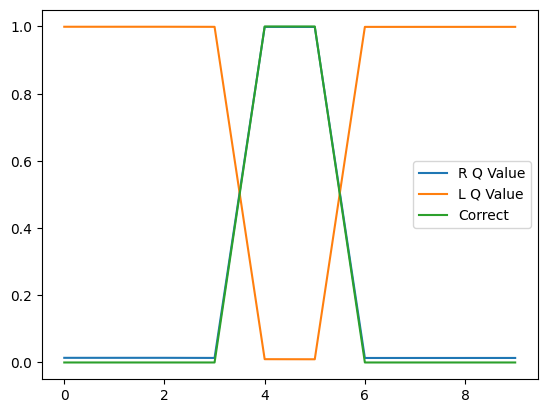

In [114]:
import matplotlib.pyplot as plt

r_q_value = []
l_q_value = []
correct_choice = []
actions = []
rewards = []
losses = []
r_prob = []
l_prob = []
for i in range(len(data)):
    curr = data[i]
    q_values = curr["q_values"]
    r_q_value.append(q_values[1])
    l_q_value.append(q_values[0])
    action_probabilities = curr["action_probabilities"]
    r_prob.append(action_probabilities[1])
    l_prob.append(action_probabilities[0])
    correct_choice.append(curr["correct_choice"])
    actions.append(curr["action"])
    rewards.append(curr["reward"])
    #losses.append(curr["loss"])

plt.plot(r_q_value[9990:], label="R Q Value")
plt.plot(l_q_value[9990:], label="L Q Value")
plt.plot(correct_choice[9990:], label="Correct")
plt.legend()

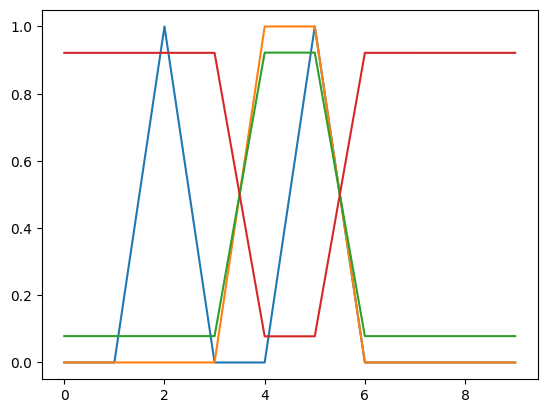

In [115]:
plt.plot(actions[9990:])
# plt.plot(rewards[990:])
plt.plot(correct_choice[9990:])
plt.plot(r_prob[9990:])
plt.plot(l_prob[9990:])

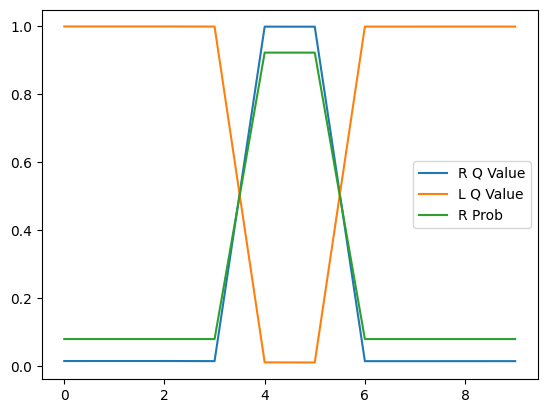

In [116]:
plt.plot(r_q_value[9990:], label="R Q Value")
plt.plot(l_q_value[9990:], label="L Q Value")
plt.plot(r_prob[9990:], label="R Prob")
plt.legend()

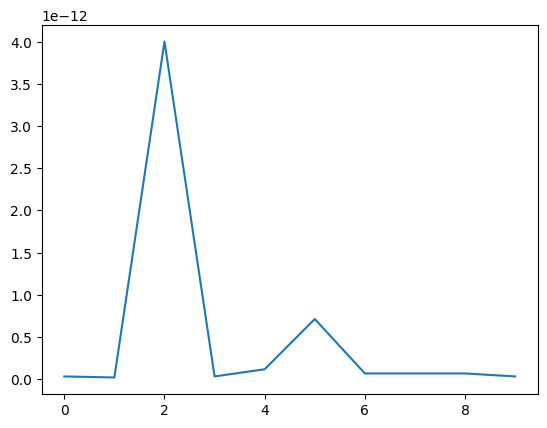

In [87]:
plt.plot(losses[990:])

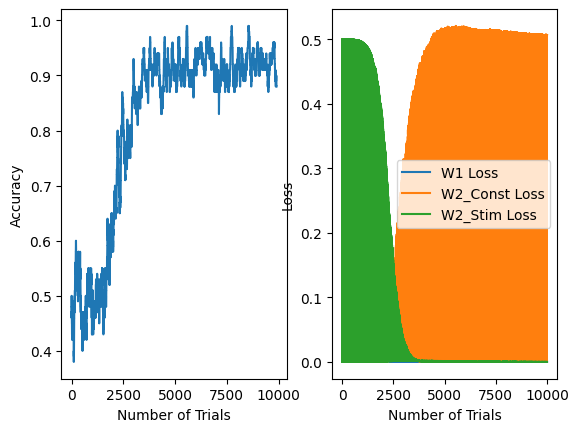

In [118]:
import src.visualization.plotting_fxns as plot

plot.plot_summary_figure(save_path)